[3, 3, 64, 23, 32, 4]


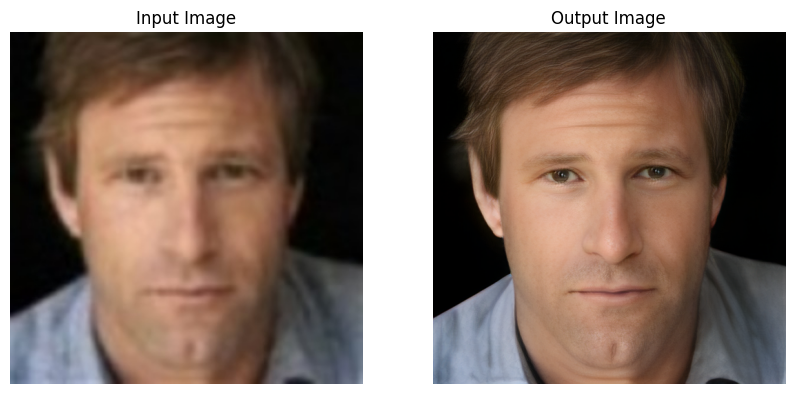

In [11]:
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn import init
from PIL import Image
from torch import nn
import functools
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)

def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()

        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32, sf=4):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)
        self.sf = sf
        print([in_nc, out_nc, nf, nb, gc, sf])

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)

        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        if self.sf==4:
            self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        if self.sf==4:
            fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out

model = RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, gc=32, sf=4).to(device)
model.load_state_dict(torch.load('C:/Users/Anyone/Downloads/BSRGANsaved.pth', map_location=torch.device('cpu')))
model.eval()

input_image = Image.open('C:/Users/Anyone/Downloads/lr.jpg')
aspect_ratio = input_image.width / input_image.height
new_size = (int(512*aspect_ratio), 512)

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
input_tensor = transform(input_image).unsqueeze(0).to(device)

with torch.no_grad():
    output_tensor = model(input_tensor)

output_image = transforms.ToPILImage()(output_tensor.squeeze(0).clamp(0, 1).detach().cpu())

output_image = output_image.resize(new_size)

fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(input_image)
axs[0].set_title(f'Input Image')
axs[0].axis('off')

axs[1].imshow(output_image)
axs[1].set_title(f'Output Image')
axs[1].axis('off')

plt.show()